This is an attempt to partially replicate the model described in ["The Evolution of Layered Protocol Stacks Leads to an Hourglass-Shaped Architecture" (Saamer Akshabi, Constantine Dovrolis)](https://www.cc.gatech.edu/~dovrolis/Papers/evoarch.pdf), for fun.

Requirements:

- graphviz package

# Model implementation

## Parameter types

In [1]:
from typing import List

def default_generalities(layers: int = 10) -> List[float]:
    return [(layers - i - 1) / layers for i in range(layers)]

print(f'Default generality vector: {default_generalities()}')

Default generality vector: [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]


In [2]:
from dataclasses import dataclass, field

@dataclass
class Params:
    generalities: List[float] = field(default_factory=default_generalities)  # aka s(l)
    competition_threshold: float = 0.6  # aka c
    init_nodes_per_layer: int = 10
    birth_rate: float = 0.05
    mortality: float = 1.0  # aka z
    min_rounds: int = 100
    max_nodes: int = 500

print(f'Default model params: {Params()}')

Default model params: Params(generalities=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0], competition_threshold=0.6, init_nodes_per_layer=10, birth_rate=0.05, mortality=1.0, min_rounds=100, max_nodes=500)


## Model classes and initialization code

In [3]:
from __future__ import annotations
from typing import Dict, Set
import random

@dataclass(eq=False)
class Node:
    product_nids: Set[int] = field(default_factory=set)
    substrate_nids: Set[int] = field(default_factory=set)
    value: int = 0

@dataclass(eq=False)
class Layer:
    nodes: Dict[int, Node] = field(default_factory=dict)

@dataclass(eq=False)
class Arch:
    params: Params
    rounds_done: int = 0
    layers: List[Layer] = field(default_factory=list)
    prev_nid: int = 0
    
    def next_nid(self) -> int:
        self.prev_nid += 1
        return self.prev_nid
    
    def node_count(self) -> int:
        return sum(len(layer.nodes) for layer in self.layers)

def assign_substrates(arch: Arch, lid: int, nid: int) -> None:
    if lid == 0:
        return
    generality = arch.params.generalities[lid-1]
    node = arch.layers[lid].nodes[nid]
    for candidate_nid, candidate in arch.layers[lid-1].nodes.items():
        if random.random() < generality:
            candidate.product_nids.add(nid)
            node.substrate_nids.add(candidate_nid)
    # Make sure each node has at least one substrate
    if not node.substrate_nids:
        substrate_nid, substrate = random.choice(list(arch.layers[lid-1].nodes.items()))
        substrate.product_nids.add(nid)
        node.substrate_nids.add(substrate_nid)

def update_value(arch: Arch, lid: int, nid: int) -> None:
    node = arch.layers[lid].nodes[nid]
    if lid == len(arch.layers) - 1:
        node.value = 1
    else:
        node.value = sum(arch.layers[lid+1].nodes[p].value for p in node.product_nids)

def create_arch(params):
    arch = Arch(params)
    nlayers = len(params.generalities)
    
    # Create initial nodes
    for i in range(nlayers):
        layer = Layer()
        for j in range(params.init_nodes_per_layer):
            layer.nodes[arch.next_nid()] = Node()
        arch.layers.append(layer)
    
    # Choose substrates for initial nodes and calculate values
    for lid in reversed(range(nlayers)):
        for nid in arch.layers[lid].nodes:
            update_value(arch, lid, nid)
            assign_substrates(arch, lid, nid)
    
    return arch

random.seed(1000)
_ = create_arch(Params()) # just making sure it runs without error

## Directed graph visualization

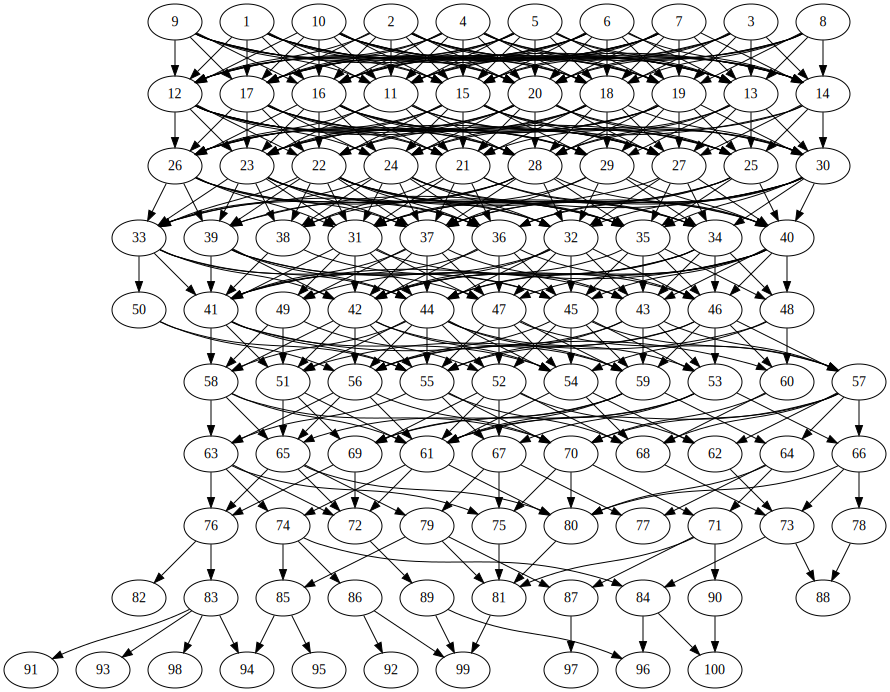

In [4]:
from graphviz import Digraph

def arch_graph(arch: Arch) -> Digraph:
    dg = Digraph()

    for layer in arch.layers:
        for nid, node in layer.nodes.items():
            dg.node(str(nid))
            for product_nid in node.product_nids:
                dg.edge(str(nid), str(product_nid))

    return dg

random.seed(1000)
arch_graph(create_arch(Params())) # making sure this works

## Model execution code

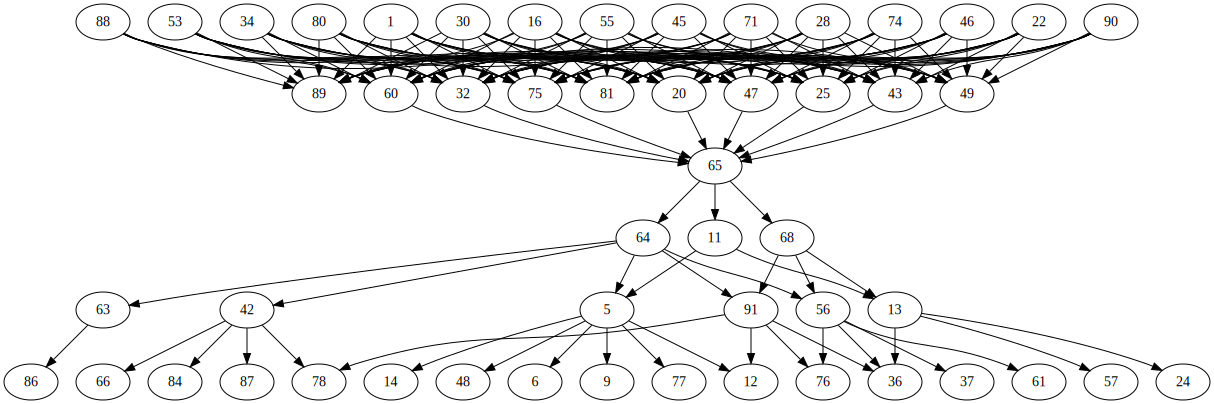

In [7]:
import math

def assign_products(arch: Arch, lid: int, nid: int, max_product_nid: int) -> None:
    if lid == len(arch.layers) - 1:
        return
    generality = arch.params.generalities[lid]
    node = arch.layers[lid].nodes[nid]
    for candidate_nid, candidate in arch.layers[lid+1].nodes.items():
        if candidate_nid <= max_product_nid and random.random() < generality:
            node.product_nids.add(candidate_nid)
            candidate.substrate_nids.add(nid)

def competitor_value(arch: Arch, lid: int, nid: int) -> int:
    node = arch.layers[lid].nodes[nid]
    nproducts = len(node.product_nids)
    if nproducts == 0:
        return 0
    strongest = 0
    for candidate_nid, candidate in arch.layers[lid].nodes.items():
        if candidate_nid == nid:
            continue
        if len(candidate.product_nids & node.product_nids) / nproducts >= arch.params.competition_threshold:
            strongest = max(strongest, candidate.value)
    return strongest

def death_probability(arch: Arch, lid: int, nid: int) -> float:
    cv = competitor_value(arch, lid, nid)
    if cv == 0:
        return 0.0
    v = arch.layers[lid].nodes[nid].value
    r = v/cv
    if r >= 1.0:
        return 0.0
    return math.e ** ((-arch.params.mortality * r) / (1 - r))

def kill_node(arch: Arch, lid: int, nid: int) -> None:
    node = arch.layers[lid].nodes[nid]
    del arch.layers[lid].nodes[nid]
    for substrate_nid in node.substrate_nids:
        substrate = arch.layers[lid-1].nodes[substrate_nid]
        substrate.product_nids.remove(nid)
    for product_nid in node.product_nids:
        product = arch.layers[lid+1].nodes[product_nid]
        product.substrate_nids.remove(nid)
        if not product.substrate_nids:
            kill_node(arch, lid+1, product_nid)

def run_round(arch: Arch) -> None:
    # Birth new nodes
    size = arch.node_count()
    birth_count = round(arch.params.birth_rate * size) or 1
    max_old_nid = arch.prev_nid
    for i in range(birth_count):
        lid = random.randrange(len(arch.layers))
        node = Node()
        nid = arch.next_nid()
        arch.layers[lid].nodes[nid] = node
    
    for lid in reversed(range(len(arch.layers))):
        layer = arch.layers[lid]
        
        # Assign substrates/products to new nodes
        for nid in layer.nodes:
            if nid > max_old_nid:
                assign_substrates(arch, lid, nid)
                assign_products(arch, lid, nid, max_old_nid)
        
        # Update values
        for nid in layer.nodes:
            update_value(arch, lid, nid)
        
        # Kill some nodes
        desc_value = sorted(layer.nodes.items(), key=lambda item: item[1].value, reverse=True)
        for nid, _ in desc_value:
            if death_probability(arch, lid, nid) > random.random():
                kill_node(arch, lid, nid)
    
    arch.rounds_done += 1

def run_to_completion(arch: Arch) -> None:
    while arch.rounds_done < arch.params.min_rounds or arch.node_count() <= arch.params.max_nodes:
        run_round(arch)

# a small test
random.seed(1000)
arch = create_arch(Params(max_nodes=50, init_nodes_per_layer=1, min_rounds=1, generalities=default_generalities(6)))
run_to_completion(arch)
arch_graph(arch)